<a href="https://colab.research.google.com/github/Meitnerium-109/citation_network_analysis/blob/main/Task_3_Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import roc_auc_score


import torch
import torch.nn as nn
import torch.optim as optim

!pip install node2vec
from node2vec import Node2Vec

!wget "https://snap.stanford.edu/data/cit-HepPh.txt.gz"
!gunzip cit-HepPh.txt.gz
!wget "https://snap.stanford.edu/data/cit-HepPh-dates.txt.gz"
!gunzip cit-HepPh-dates.txt.gz


edge_file = 'cit-HepPh.txt'
dates_file = 'cit-HepPh-dates.txt'
citations = pd.read_csv(edge_file, sep='\t', comment='#', names=['source','target'])
dates = pd.read_csv(dates_file, sep='\t', names=['node','date'], comment='#')
dates['date'] = pd.to_datetime(dates['date'], format='%Y-%m-%d', errors='coerce')


G = nx.from_pandas_edgelist(citations, 'source','target', create_using=nx.DiGraph())

print(f"Total nodes: {G.number_of_nodes()}, Total edges: {G.number_of_edges()}")

--2024-12-21 16:38:18--  https://snap.stanford.edu/data/cit-HepPh.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1664504 (1.6M) [application/x-gzip]
Saving to: ‘cit-HepPh.txt.gz’

cit-HepPh.txt.gz    100%[===================>]   1.59M  4.34MB/s    in 0.4s    

2024-12-21 16:38:19 (4.34 MB/s) - ‘cit-HepPh.txt.gz’ saved [1664504/1664504]

--2024-12-21 16:38:19--  https://snap.stanford.edu/data/cit-HepPh-dates.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96569 (94K) [application/x-gzip]
Saving to: ‘cit-HepPh-dates.txt.gz’

cit-HepPh-dates.txt 100%[===================>]  94.31K  --.-KB/s    in 0.07s   

2024-12-21 16:38:19 (1.27 MB/s) - ‘cit-HepPh-dates.txt.gz’ saved 

In [3]:
T = 2000
dates_map = dates.set_index('node')['date'].to_dict()

def is_train_edge(u,v):
    du = dates_map.get(u, None)
    dv = dates_map.get(v, None)
    if du and dv:
        return (du.year <= T) and (dv.year <= T)
    return False

G_train = nx.DiGraph()
G_test_edges = []

for u,v in G.edges():
    if is_train_edge(u,v):
        G_train.add_edge(u,v)
    else:
        G_test_edges.append((u,v))

print(f"Training graph edges: {G_train.number_of_edges()}, Test edges: {len(G_test_edges)}")

Training graph edges: 263468, Test edges: 158110


In [4]:

train_undirected = G_train.to_undirected()
node2vec = Node2Vec(train_undirected, dimensions=64, walk_length=20, num_walks=50, workers=2)
n2v_model = node2vec.fit(window=5, min_count=1, batch_words=4)

def edge_score(u,v):
    if (str(u) in n2v_model.wv) and (str(v) in n2v_model.wv):
        return np.dot(n2v_model.wv[str(u)], n2v_model.wv[str(v)])
    return 0


pos_test = random.sample(G_test_edges, min(5000, len(G_test_edges)))
all_nodes = list(G_train.nodes())
neg_test = []
while len(neg_test) < len(pos_test):
    a, b = random.sample(all_nodes, 2)
    if not G_train.has_edge(a,b):
        neg_test.append((a,b))

y_true = [1]*len(pos_test) + [0]*len(neg_test)
edges_test = pos_test + neg_test
scores = [edge_score(u,v) for (u,v) in edges_test]
n2v_auc = roc_auc_score(y_true, scores)
print(f"Node2Vec Test AUC: {n2v_auc:.4f}")

Computing transition probabilities:   0%|          | 0/25638 [00:00<?, ?it/s]

Node2Vec Test AUC: 0.0026


In [5]:

train_nodes = list(G_train.nodes())
idx_map = {n:i for i,n in enumerate(train_nodes)}

size = len(train_nodes)
adj = np.zeros((size,size), dtype=np.float32)
for u,v in G_train.edges():
    adj[idx_map[u], idx_map[v]] = 1


features = nn.Embedding(size, 64)
torch_adj = torch.from_numpy(adj)

class SimpleGNN(nn.Module):
    def __init__(self, num_nodes, emb_dim=64):
        super(SimpleGNN, self).__init__()
        self.linear = nn.Linear(emb_dim, emb_dim)
    def forward(self):
        x = features.weight
        # Basic message passing simulation
        Ax = torch.mm(torch_adj, x)
        hx = self.linear(Ax)
        return hx

model = SimpleGNN(size)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Training pairs
pos_edges = np.array([[idx_map[u], idx_map[v]] for u,v in G_train.edges() if u in idx_map and v in idx_map])
neg_edges = []
while len(neg_edges) < len(pos_edges):
    a, b = random.sample(train_nodes, 2)
    if not G_train.has_edge(a,b):
        neg_edges.append((idx_map[a], idx_map[b]))
neg_edges = np.array(neg_edges)

def batch_data(batch_size=1024):
    idx = np.random.choice(len(pos_edges), batch_size//2)
    batch_pos = pos_edges[idx]
    idx_neg = np.random.choice(len(neg_edges), batch_size//2)
    batch_neg = neg_edges[idx_neg]
    X = np.vstack((batch_pos, batch_neg))
    y = np.concatenate([np.ones(batch_size//2), np.zeros(batch_size//2)])
    return torch.LongTensor(X), torch.FloatTensor(y)

for epoch in range(5):
    Xb, yb = batch_data()
    optimizer.zero_grad()
    embeddings = model()
    # Score edges
    e1 = embeddings[Xb[:,0]]
    e2 = embeddings[Xb[:,1]]
    logit = torch.sum(e1*e2, dim=1)
    loss = criterion(logit, yb)
    loss.backward()
    optimizer.step()
    if (epoch+1)%1==0:
        print(f"Epoch {epoch+1}, Loss={loss.item():.4f}")

Epoch 1, Loss=9.7175
Epoch 2, Loss=9.0548
Epoch 3, Loss=7.7932
Epoch 4, Loss=7.7552
Epoch 5, Loss=7.4567


In [6]:

with torch.no_grad():
    final_emb = model()
def gnn_score(u,v):
    if (u in idx_map) and (v in idx_map):
        ev = final_emb[idx_map[u]] * final_emb[idx_map[v]]
        return torch.sum(ev).item()
    return 0.0

pos_test = random.sample(G_test_edges, min(5000, len(G_test_edges)))
all_nodes = list(G_train.nodes())
neg_test = []
while len(neg_test) < len(pos_test):
    a, b = random.sample(all_nodes, 2)
    if not G_train.has_edge(a,b):
        neg_test.append((a,b))

y_true = [1]*len(pos_test) + [0]*len(neg_test)
edges_test = pos_test + neg_test
scores = [gnn_score(u,v) for (u,v) in edges_test]
gnn_auc = roc_auc_score(y_true, scores)
print(f"GNN Test AUC: {gnn_auc:.4f}")

GNN Test AUC: 0.4622


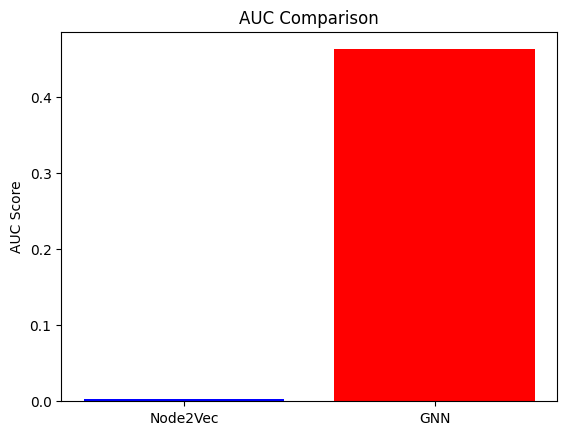

Node2Vec AUC: 0.0026, GNN AUC: 0.4622


In [7]:
methods = ['Node2Vec','GNN']
scores = [n2v_auc, gnn_auc]

plt.bar(methods, scores, color=['blue','red'])
plt.title("AUC Comparison")
plt.ylabel("AUC Score")
plt.show()

print(f"Node2Vec AUC: {n2v_auc:.4f}, GNN AUC: {gnn_auc:.4f}")

